# Paths

In [1]:
dataset_path = "./datasets/ASDID"
tensorboard_path = "logs/"
models_path = "./models/ASDID/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [4]:
from torchvision.models import resnet18, ResNet18_Weights
my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [5]:
import torch
import torchvision

data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 32

for inputs, labels in train_data:
        print("Labels:", labels)
        break

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Labels: 6


In [6]:
for inputs, labels in train_tensors:
        print("Labels:", labels.unique())
        break

Labels: tensor([1, 2, 3, 4, 5, 6, 7, 9])


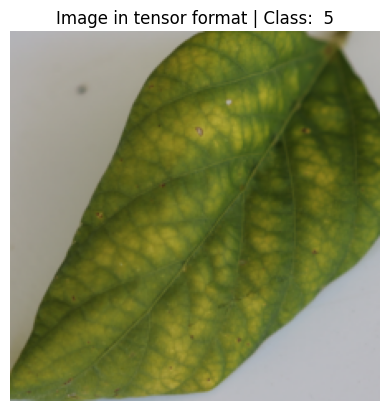

In [7]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

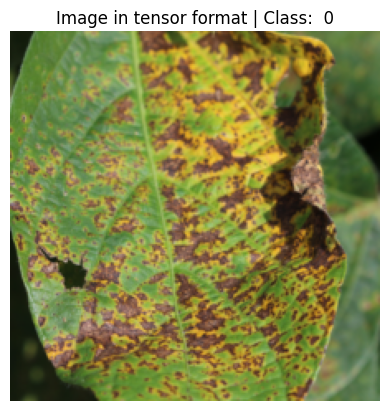

In [8]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [9]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    # optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            
            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )
            
            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )
        
        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}AlexNet-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [10]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [11]:
import torch
from torchvision.models import resnet18

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet18-SoyNet-96.07.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [12]:
for param in modelResNetTL.parameters():
    param.requires_grad = False

modelResNetTL.fc.requires_grad_(True)
num_classes = 11
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [13]:
# Check which layers are frozen
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: Frozen
layer2.0.conv2.weight: Frozen
layer2.0.bn2.weight: Frozen
layer2.0.bn2.bias: Frozen
layer2.0.downsample.0.weight: Frozen
layer2.0.downsample.1.weight: Frozen
layer2.0.downsample.1.bias: Frozen
layer2.1.conv1.weight: Frozen
layer2.1.bn1.weight: Frozen
layer2.1.bn1.bias: Frozen
layer2.1.conv2.weight: Frozen
layer2.1.bn2.weight: Frozen
layer2.1.bn2.bias: Frozen
layer3.0.conv1.weight: Frozen
layer3.0.bn1.weight: Frozen
layer3.0.bn1.bias: Frozen
layer3.0.conv2.weight: Frozen
layer3.0.bn2.weight: Frozen
layer3.0.bn2.bias: F

Running on cuda
Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7])


Training epochs...:   1%|          | 1/100 [21:10<34:56:05, 1270.35s/it]

Saving Best Model with Accuracy:  49.883759548322814
Epoch:   1 | Accuracy : 49.8838%


Training epochs...:   2%|▏         | 2/100 [41:10<33:27:49, 1229.28s/it]

Saving Best Model with Accuracy:  65.2607107273331
Epoch:   2 | Accuracy : 65.2607%


Training epochs...:   3%|▎         | 3/100 [59:45<31:42:24, 1176.75s/it]

Saving Best Model with Accuracy:  69.84390567917636
Epoch:   3 | Accuracy : 69.8439%


Training epochs...:   4%|▍         | 4/100 [1:18:05<30:34:15, 1146.41s/it]

Saving Best Model with Accuracy:  73.46396545998007
Epoch:   4 | Accuracy : 73.4640%


Training epochs...:   5%|▌         | 5/100 [1:37:49<30:36:40, 1160.00s/it]

Saving Best Model with Accuracy:  75.32381268681502
Epoch:   5 | Accuracy : 75.3238%


Training epochs...:   6%|▌         | 6/100 [1:57:44<30:35:55, 1171.86s/it]

Saving Best Model with Accuracy:  76.38658253072069
Epoch:   6 | Accuracy : 76.3866%


Training epochs...:   7%|▋         | 7/100 [2:18:16<30:47:16, 1191.79s/it]

Saving Best Model with Accuracy:  78.4124875456659
Epoch:   7 | Accuracy : 78.4125%


Training epochs...:   8%|▊         | 8/100 [2:40:39<31:40:50, 1239.68s/it]

Saving Best Model with Accuracy:  78.94387246761873
Epoch:   8 | Accuracy : 78.9439%


Training epochs...:   9%|▉         | 9/100 [3:03:45<32:29:35, 1285.44s/it]

Saving Best Model with Accuracy:  79.67452673530389
Epoch:   9 | Accuracy : 79.6745%


Training epochs...:  10%|█         | 10/100 [3:27:16<33:06:39, 1324.43s/it]

Saving Best Model with Accuracy:  80.40518100298904
Epoch:  10 | Accuracy : 80.4052%


Training epochs...:  11%|█         | 11/100 [3:57:11<36:18:09, 1468.42s/it]

Saving Best Model with Accuracy:  81.2022583859183
Epoch:  11 | Accuracy : 81.2023%


Training epochs...:  12%|█▏        | 12/100 [4:22:50<36:24:55, 1489.73s/it]

Saving Best Model with Accuracy:  81.40152773165062
Epoch:  12 | Accuracy : 81.4015%


Training epochs...:  13%|█▎        | 13/100 [4:49:20<36:44:10, 1520.12s/it]

Saving Best Model with Accuracy:  82.43108601793423
Epoch:  13 | Accuracy : 82.4311%


Training epochs...:  14%|█▍        | 14/100 [5:15:09<36:31:13, 1528.77s/it]

Saving Best Model with Accuracy:  82.69677847891066
Epoch:  14 | Accuracy : 82.6968%


Training epochs...:  15%|█▌        | 15/100 [5:42:52<37:03:17, 1569.38s/it]

Epoch:  15 | Accuracy : 81.9993%


Training epochs...:  16%|█▌        | 16/100 [6:05:35<35:10:00, 1507.15s/it]

Saving Best Model with Accuracy:  83.32779807372965
Epoch:  16 | Accuracy : 83.3278%


Training epochs...:  17%|█▋        | 17/100 [6:31:38<35:08:11, 1524.00s/it]

Saving Best Model with Accuracy:  83.65991364995018
Epoch:  17 | Accuracy : 83.6599%


Training epochs...:  18%|█▊        | 18/100 [6:51:38<32:29:52, 1426.73s/it]

Saving Best Model with Accuracy:  83.89239455330456
Epoch:  18 | Accuracy : 83.8924%


Training epochs...:  19%|█▉        | 19/100 [7:11:05<30:20:51, 1348.79s/it]

Saving Best Model with Accuracy:  84.19129857190302
Epoch:  19 | Accuracy : 84.1913%


Training epochs...:  20%|██        | 20/100 [7:30:20<28:40:41, 1290.52s/it]

Epoch:  20 | Accuracy : 84.1249%


Training epochs...:  21%|██        | 21/100 [7:49:35<27:25:39, 1249.87s/it]

Epoch:  21 | Accuracy : 83.9588%


Training epochs...:  22%|██▏       | 22/100 [8:08:51<26:28:05, 1221.60s/it]

Saving Best Model with Accuracy:  84.35735636001328
Epoch:  22 | Accuracy : 84.3574%


Training epochs...:  23%|██▎       | 23/100 [8:28:07<25:42:42, 1202.11s/it]

Saving Best Model with Accuracy:  84.68947193623382
Epoch:  23 | Accuracy : 84.6895%


Training epochs...:  24%|██▍       | 24/100 [8:47:24<25:05:17, 1188.39s/it]

Saving Best Model with Accuracy:  84.78910660909996
Epoch:  24 | Accuracy : 84.7891%


Training epochs...:  25%|██▌       | 25/100 [9:06:38<24:32:30, 1178.00s/it]

Saving Best Model with Accuracy:  84.98837595483228
Epoch:  25 | Accuracy : 84.9884%


Training epochs...:  26%|██▌       | 26/100 [9:25:08<23:47:39, 1157.56s/it]

Epoch:  26 | Accuracy : 84.3574%


Training epochs...:  27%|██▋       | 27/100 [9:43:39<23:11:37, 1143.81s/it]

Epoch:  27 | Accuracy : 84.1581%


Training epochs...:  28%|██▊       | 28/100 [10:02:00<22:37:08, 1130.95s/it]

Saving Best Model with Accuracy:  85.75224178013949
Epoch:  28 | Accuracy : 85.7522%


Training epochs...:  29%|██▉       | 29/100 [10:20:32<22:11:35, 1125.29s/it]

Epoch:  29 | Accuracy : 84.9884%


Training epochs...:  30%|███       | 30/100 [10:39:05<21:48:27, 1121.54s/it]

Saving Best Model with Accuracy:  85.91829956824975
Epoch:  30 | Accuracy : 85.9183%


Training epochs...:  31%|███       | 31/100 [10:57:50<21:30:54, 1122.53s/it]

Epoch:  31 | Accuracy : 85.3205%


Training epochs...:  32%|███▏      | 32/100 [11:15:57<21:00:16, 1112.01s/it]

Epoch:  32 | Accuracy : 85.8187%


Training epochs...:  33%|███▎      | 33/100 [11:34:30<20:41:54, 1112.16s/it]

Epoch:  33 | Accuracy : 85.7190%


Training epochs...:  34%|███▍      | 34/100 [11:53:12<20:26:35, 1115.09s/it]

Epoch:  34 | Accuracy : 85.5862%


Training epochs...:  35%|███▌      | 35/100 [12:12:03<20:13:07, 1119.80s/it]

Epoch:  35 | Accuracy : 85.8519%


Training epochs...:  36%|███▌      | 36/100 [12:31:01<20:00:17, 1125.28s/it]

Epoch:  36 | Accuracy : 85.3537%


Training epochs...:  37%|███▋      | 37/100 [12:50:25<19:53:46, 1136.92s/it]

Epoch:  37 | Accuracy : 85.6526%


Training epochs...:  38%|███▊      | 38/100 [13:09:33<19:38:13, 1140.22s/it]

Epoch:  38 | Accuracy : 85.9183%


Training epochs...:  39%|███▉      | 39/100 [13:28:05<19:10:43, 1131.85s/it]

Saving Best Model with Accuracy:  86.05114579873796
Epoch:  39 | Accuracy : 86.0511%


Training epochs...:  40%|████      | 40/100 [13:46:36<18:45:29, 1125.50s/it]

Saving Best Model with Accuracy:  86.15078047160412
Epoch:  40 | Accuracy : 86.1508%


Training epochs...:  41%|████      | 41/100 [14:04:57<18:19:45, 1118.40s/it]

Epoch:  41 | Accuracy : 85.5862%


Training epochs...:  42%|████▏     | 42/100 [14:22:24<17:40:12, 1096.77s/it]

Epoch:  42 | Accuracy : 85.8519%


Training epochs...:  43%|████▎     | 43/100 [14:39:41<17:04:51, 1078.80s/it]

Epoch:  43 | Accuracy : 85.6194%


Training epochs...:  44%|████▍     | 44/100 [14:57:53<16:50:38, 1082.82s/it]

Saving Best Model with Accuracy:  86.38326137495848
Epoch:  44 | Accuracy : 86.3833%


Training epochs...:  45%|████▌     | 45/100 [15:15:38<16:27:46, 1077.58s/it]

Saving Best Model with Accuracy:  86.68216539355696
Epoch:  45 | Accuracy : 86.6822%


Training epochs...:  46%|████▌     | 46/100 [15:33:22<16:05:59, 1073.33s/it]

Epoch:  46 | Accuracy : 86.1840%


Training epochs...:  47%|████▋     | 47/100 [15:50:59<15:43:46, 1068.43s/it]

Epoch:  47 | Accuracy : 86.4829%


Training epochs...:  48%|████▊     | 48/100 [16:08:45<15:25:24, 1067.78s/it]

Epoch:  48 | Accuracy : 86.2836%


Training epochs...:  49%|████▉     | 49/100 [16:26:28<15:06:25, 1066.39s/it]

Epoch:  49 | Accuracy : 86.4829%


Training epochs...:  50%|█████     | 50/100 [16:44:06<14:46:35, 1063.90s/it]

Epoch:  50 | Accuracy : 86.3500%


Training epochs...:  51%|█████     | 51/100 [17:01:36<14:25:22, 1059.65s/it]

Epoch:  51 | Accuracy : 85.9847%


Training epochs...:  52%|█████▏    | 52/100 [17:19:26<14:10:16, 1062.85s/it]

Epoch:  52 | Accuracy : 86.4165%


Training epochs...:  53%|█████▎    | 53/100 [17:37:10<13:52:42, 1063.02s/it]

Epoch:  53 | Accuracy : 86.5825%


Training epochs...:  54%|█████▍    | 54/100 [17:54:38<13:31:31, 1058.51s/it]

Epoch:  54 | Accuracy : 86.6490%


Training epochs...:  55%|█████▌    | 55/100 [18:12:04<13:11:05, 1054.80s/it]

Epoch:  55 | Accuracy : 86.6157%


Training epochs...:  56%|█████▌    | 56/100 [18:29:31<12:51:58, 1052.69s/it]

Epoch:  56 | Accuracy : 86.4829%


Training epochs...:  57%|█████▋    | 57/100 [18:46:56<12:32:44, 1050.35s/it]

Saving Best Model with Accuracy:  86.74858850880106
Epoch:  57 | Accuracy : 86.7486%


Training epochs...:  58%|█████▊    | 58/100 [19:04:16<12:13:05, 1047.26s/it]

Saving Best Model with Accuracy:  86.94785785453338
Epoch:  58 | Accuracy : 86.9479%


Training epochs...:  59%|█████▉    | 59/100 [19:21:41<11:55:10, 1046.59s/it]

Epoch:  59 | Accuracy : 86.6157%


Training epochs...:  60%|██████    | 60/100 [19:39:18<11:39:39, 1049.48s/it]

Epoch:  60 | Accuracy : 86.3833%


Training epochs...:  61%|██████    | 61/100 [19:56:40<11:20:46, 1047.35s/it]

Epoch:  61 | Accuracy : 86.5161%


Training epochs...:  62%|██████▏   | 62/100 [20:14:32<11:07:59, 1054.72s/it]

Saving Best Model with Accuracy:  86.98106941215543
Epoch:  62 | Accuracy : 86.9811%


Training epochs...:  63%|██████▎   | 63/100 [20:33:06<11:01:25, 1072.57s/it]

Epoch:  63 | Accuracy : 86.5161%


Training epochs...:  64%|██████▍   | 64/100 [20:51:56<10:53:52, 1089.79s/it]

Saving Best Model with Accuracy:  87.346396545998
Epoch:  64 | Accuracy : 87.3464%


Training epochs...:  65%|██████▌   | 65/100 [21:10:32<10:40:13, 1097.51s/it]

Epoch:  65 | Accuracy : 86.6822%


Training epochs...:  66%|██████▌   | 66/100 [21:37:15<11:47:55, 1249.28s/it]

Epoch:  66 | Accuracy : 86.6822%


Training epochs...:  67%|██████▋   | 67/100 [21:58:45<11:33:52, 1261.59s/it]

Epoch:  67 | Accuracy : 87.2800%


Training epochs...:  68%|██████▊   | 68/100 [22:16:59<10:46:02, 1211.32s/it]

Epoch:  68 | Accuracy : 87.0807%


Training epochs...:  69%|██████▉   | 69/100 [22:35:18<10:08:25, 1177.60s/it]

Epoch:  69 | Accuracy : 86.5825%


Training epochs...:  70%|███████   | 70/100 [22:53:52<9:39:08, 1158.28s/it] 

Saving Best Model with Accuracy:  87.41281966124211
Epoch:  70 | Accuracy : 87.4128%


Training epochs...:  71%|███████   | 71/100 [23:12:08<9:10:50, 1139.66s/it]

Epoch:  71 | Accuracy : 86.9811%


Training epochs...:  72%|███████▏  | 72/100 [23:30:06<8:43:13, 1121.18s/it]

Epoch:  72 | Accuracy : 86.8482%


Training epochs...:  73%|███████▎  | 73/100 [23:48:30<8:22:12, 1116.03s/it]

Epoch:  73 | Accuracy : 86.8482%


Training epochs...:  74%|███████▍  | 74/100 [24:07:06<8:03:34, 1115.96s/it]

Epoch:  74 | Accuracy : 87.3132%


Training epochs...:  75%|███████▌  | 75/100 [24:25:47<7:45:38, 1117.54s/it]

Epoch:  75 | Accuracy : 86.9146%


Training epochs...:  76%|███████▌  | 76/100 [24:44:33<7:28:04, 1120.17s/it]

Epoch:  76 | Accuracy : 86.9811%


Training epochs...:  77%|███████▋  | 77/100 [25:03:38<7:12:10, 1127.42s/it]

Epoch:  77 | Accuracy : 87.0807%


Training epochs...:  78%|███████▊  | 78/100 [25:22:38<6:54:48, 1131.28s/it]

Epoch:  78 | Accuracy : 86.9479%


Training epochs...:  79%|███████▉  | 79/100 [25:41:14<6:34:22, 1126.78s/it]

Epoch:  79 | Accuracy : 86.8814%


Training epochs...:  80%|████████  | 80/100 [26:00:15<6:16:58, 1130.90s/it]

Epoch:  80 | Accuracy : 87.0475%


Training epochs...:  81%|████████  | 81/100 [26:19:19<5:59:26, 1135.09s/it]

Epoch:  81 | Accuracy : 86.9811%


Training epochs...:  82%|████████▏ | 82/100 [26:38:26<5:41:34, 1138.61s/it]

Saving Best Model with Accuracy:  87.47924277648622
Epoch:  82 | Accuracy : 87.4792%


Training epochs...:  83%|████████▎ | 83/100 [26:56:44<5:19:09, 1126.46s/it]

Epoch:  83 | Accuracy : 87.2468%


Training epochs...:  84%|████████▍ | 84/100 [27:15:58<5:02:34, 1134.63s/it]

Epoch:  84 | Accuracy : 86.9479%


Training epochs...:  85%|████████▌ | 85/100 [27:35:26<4:46:09, 1144.60s/it]

Epoch:  85 | Accuracy : 86.7154%


Training epochs...:  86%|████████▌ | 86/100 [27:54:43<4:27:57, 1148.37s/it]

Epoch:  86 | Accuracy : 87.0143%


Training epochs...:  87%|████████▋ | 87/100 [28:14:02<4:09:27, 1151.37s/it]

Epoch:  87 | Accuracy : 87.0807%


Training epochs...:  88%|████████▊ | 88/100 [28:33:21<3:50:44, 1153.72s/it]

Epoch:  88 | Accuracy : 87.2136%


Training epochs...:  89%|████████▉ | 89/100 [28:52:43<3:31:58, 1156.24s/it]

Epoch:  89 | Accuracy : 86.5825%


Training epochs...:  90%|█████████ | 90/100 [29:11:46<3:12:02, 1152.27s/it]

Epoch:  90 | Accuracy : 86.7154%


Training epochs...:  91%|█████████ | 91/100 [29:30:43<2:52:10, 1147.80s/it]

Epoch:  91 | Accuracy : 86.9146%


Training epochs...:  92%|█████████▏| 92/100 [29:49:41<2:32:39, 1144.88s/it]

Epoch:  92 | Accuracy : 86.7154%


Training epochs...:  93%|█████████▎| 93/100 [30:08:26<2:12:52, 1138.95s/it]

Epoch:  93 | Accuracy : 87.1471%


Training epochs...:  94%|█████████▍| 94/100 [30:27:09<1:53:23, 1133.97s/it]

Epoch:  94 | Accuracy : 87.2468%


Training epochs...:  95%|█████████▌| 95/100 [30:45:50<1:34:10, 1130.02s/it]

Epoch:  95 | Accuracy : 87.1139%


Training epochs...:  96%|█████████▌| 96/100 [31:04:30<1:15:08, 1127.07s/it]

Epoch:  96 | Accuracy : 87.0143%


Training epochs...:  97%|█████████▋| 97/100 [31:23:13<56:17, 1125.79s/it]  

Epoch:  97 | Accuracy : 86.8814%


Training epochs...:  98%|█████████▊| 98/100 [31:41:53<37:28, 1124.23s/it]

Epoch:  98 | Accuracy : 87.0475%


Training epochs...:  99%|█████████▉| 99/100 [32:00:33<18:42, 1122.88s/it]

Epoch:  99 | Accuracy : 87.0807%


Training epochs...: 100%|██████████| 100/100 [32:19:12<00:00, 1163.53s/it]

Epoch: 100 | Accuracy : 87.1803%


Model saved in: ./models/ASDID/AlexNet-ASDID-87.48.pkl


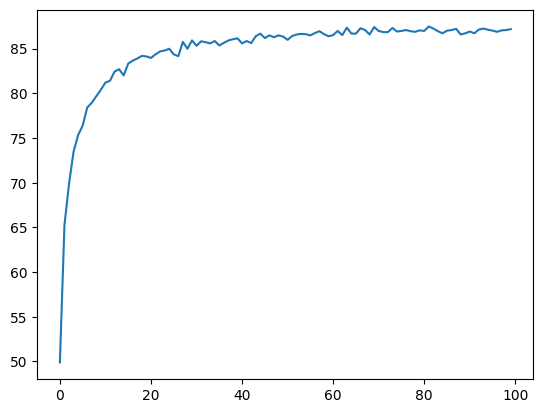

In [14]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-4
dataset = 'ASDID'
prefix = 'ResNet18-Adam-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 732
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
3
Predicted: Frogeye | Corrected: Frogeye | Confidence: 86.50%


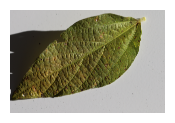

In [15]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    # my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "BacterialBlight", "CercosporaLeafBlight", "DowneyMildew", "Frogeye", "Healthy", "PotassiumDeficiency",
        "SoybeanRust", "TargetSpot", "UnusedCercosporaLeafBlight", "UnusedHealthy", "UnusedSoybeanRust"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
